## Test on a simple case
Consider the following Possion Equation
$$
\begin{cases}
    \Delta u = 1\qquad &u\in\Omega\\
    u = 0\qquad &u\in\partial\Omega.
\end{cases}$$
Here $\Omega = \{(x, y)|x^2+y^2 < 1\}$

The exact solution to this problem is $$u = \frac{1}{4}(x^2+y^2-1).$$

In [192]:
% matplotlib inline
import torch 
import torch.nn.functional as F
import numpy as np
from math import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm

torch.set_default_tensor_type('torch.FloatTensor')

m = 10
learning_rate = 0.01
iterations = 110  #default 10000
print_every_iter = 100
beta = 500 #coefficient for the regularization term in the loss expression, is set to be 1000 in section 3.1
n1 = 1000 #number of points in (0,1)^m
n2 = 100  #number of points on the border of (0,1)^m
n3 = 100  #number of points used for evaluating the error

class DeepRitzNet(torch.nn.Module):
    def __init__(self, m):
        super(DeepRitzNet, self).__init__()
        self.linear1 = torch.nn.Linear(m,m)
        self.linear2 = torch.nn.Linear(m,m)
        self.linear3 = torch.nn.Linear(m,m)
        self.linear4 = torch.nn.Linear(m,m)
        self.linear5 = torch.nn.Linear(m,m)
        self.linear6 = torch.nn.Linear(m,m)
        
        self.linear7 = torch.nn.Linear(m,1)
    
    def forward(self, x):
        y = x
        y = y + F.relu(self.linear2(F.relu(self.linear1(y))))
        y = y + F.relu(self.linear4(F.relu(self.linear3(y))))
        y = y + F.relu(self.linear6(F.relu(self.linear5(y))))
        output = F.relu(self.linear7(y))
        return output

In [190]:
def draw_graph():
    points = np.arange(-1, 1, 0.1)
    xs, ys = np.meshgrid(points, points)
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    xl, yl = xs.size()
    z = np.zeros((xl, yl))
    mmm = 0
    for i in range(xl):
        for j in range(yl):      
            re = np.zeros(m)
            re[0] = xs[i, j]
            re[1] = ys[i, j]
            re = torch.tensor(re)        
            z[i, j] = model(re.float()).item() + U_groundtruth(re)
            if re[0] ** 2 + re[1] ** 2 < 1 and abs(z[i, j]) > mmm:
                mmm = abs(z[i, j])
    
    plt.imshow(z, cmap=cm.hot)
    plt.colorbar()
    plt.show()
    print(mmm)

In [186]:
#U_groundtruth = 1/4*(x^2+y^2)-1/4
#take in a (m,) tensor (x, y, ...)
def U_groundtruth(t):
    #re = 0
    re = (t[0] ** 2 + t[1] ** 2 - 1).item() / 4
    return re

#turn a (2,) tensor/ndarray to a (m,) tensor
def zeropad(x_2, m):
    x_10 = torch.zeros(m, )
    x_10[0] = x_2[0]
    x_10[1] = x_2[1]
    return x_10
    
#sample a (m,) tensor on the border of the unit circle
def on_sample(m):
    theta = np.random.rand() * 2 * pi
    re = np.zeros(m)
    re[0] = cos(theta)
    re[1] = sin(theta)
    re = torch.tensor(re, requires_grad=True)
    return re

#sample a (m,) tensor in the unit circle
def in_sample(m):
    r = sqrt(np.random.rand())
    theta = np.random.rand() * 2 * pi
    re = np.zeros(m)
    re[0] = r * cos(theta)
    re[1] = r * sin(theta)
    re = torch.tensor(re, requires_grad=True)
    return re

In [193]:
model = DeepRitzNet(m)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
in_error_iter = [] #record the error in Omega every print_every_iter=100 times
on_error_iter = [] #record the error on the border of Omega every print_every_iter=100 times

mm = 1
for i in range(iterations):
    #calculate the loss 
    loss = torch.zeros(1)
    for t in range(n1):
        #if I miss out the ".float()" there will be an error and I don't know why
        #It seems to have something to do with the usage of relu()**3 in DeepRitzNet
        x_input = in_sample(m)
        y = model(x_input.float())
        #there will be an error without "retain_graph=True" , I don't know why
        #y.backward(retain_graph = True)
        
        x1 = torch.zeros(m)
        x2 = torch.zeros(m)
        x1[0] = 0.0001
        x2[1] = 0.0001
        x_input_1 = x_input.float() + x1
        x_input_2 = x_input.float() + x2
        x_input_grad_1 = (model(x_input_1) - y) / 0.0001
        x_input_grad_2 = (model(x_input_2) - y) / 0.0001

        loss += 0.5 * ((x_input_grad_1) ** 2 + (x_input_grad_2) ** 2) - y
        #loss += 0.5 * ((x_input.grad.float()[0]) ** 2 + (x_input.grad.float()[1]) ** 2) + y
    loss /= n1

    regularization = torch.zeros(1)
    for t in range(n2):
        x_input = on_sample(m).float()
        y = model(x_input)
        regularization += y**2 
    regularization *= mm / n2
    if mm < 500:
        mm = mm * 1.015
    
    #draw_graph()
    print(i, " epoch, loss: ", loss.data[0].numpy())
    print(i, " epoch, regularization loss: ", regularization.data[0].numpy())
    
    loss += regularization
    
    #and step the optimizer
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

        
print("Traning Completed.")

0  epoch, loss:  -0.005310496781021357
0  epoch, regularization loss:  0.005188044160604477
1  epoch, loss:  -0.037098683416843414
1  epoch, regularization loss:  0.02654002420604229
2  epoch, loss:  -0.0869927778840065
2  epoch, regularization loss:  0.05338403210043907
3  epoch, loss:  -0.1584429144859314
3  epoch, regularization loss:  0.09270234405994415
4  epoch, loss:  -0.2437284290790558
4  epoch, regularization loss:  0.1355186253786087
5  epoch, loss:  -0.34098970890045166
5  epoch, regularization loss:  0.19450755417346954
6  epoch, loss:  -0.4384140372276306
6  epoch, regularization loss:  0.2532362639904022
7  epoch, loss:  -0.509207010269165
7  epoch, regularization loss:  0.33293288946151733
8  epoch, loss:  -0.5596131086349487
8  epoch, regularization loss:  0.36735913157463074
9  epoch, loss:  -0.5763107538223267
9  epoch, regularization loss:  0.3649887144565582
10  epoch, loss:  -0.5617523193359375
10  epoch, regularization loss:  0.342189222574234
11  epoch, loss:  -

91  epoch, loss:  -0.18211683630943298
91  epoch, regularization loss:  0.059081338346004486
92  epoch, loss:  -0.18763555586338043
92  epoch, regularization loss:  0.07316742837429047
93  epoch, loss:  -0.1888303905725479
93  epoch, regularization loss:  0.07469496130943298
94  epoch, loss:  -0.18485818803310394
94  epoch, regularization loss:  0.07190169394016266
95  epoch, loss:  -0.16858625411987305
95  epoch, regularization loss:  0.058414023369550705
96  epoch, loss:  -0.16127514839172363
96  epoch, regularization loss:  0.04649486392736435
97  epoch, loss:  -0.1658908873796463
97  epoch, regularization loss:  0.058266956359148026
98  epoch, loss:  -0.1782497763633728
98  epoch, regularization loss:  0.0697932317852974
99  epoch, loss:  -0.1794588267803192
99  epoch, regularization loss:  0.06923944503068924
100  epoch, loss:  -0.16755709052085876
100  epoch, regularization loss:  0.062471870332956314
101  epoch, loss:  -0.15303181111812592
101  epoch, regularization loss:  0.047

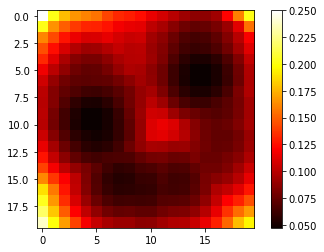

0.127406805754


In [195]:
draw_graph()

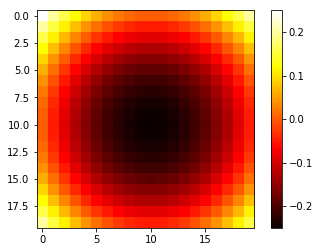

In [150]:
draw_graph()

0.0767963904142
0.0767694622278
0.0816443055868
0.0800512599945
0.0727235519886
0.0703958141804
0.0665646582842
0.0614262133837
0.0612878131866
0.0622562801838
0.0654799461365
0.0725226056576
0.0778143239021
0.0802701622248
0.0814826673269
0.0749116152525
0.0647732001543
0.0596347999573
0.0594963848591
0.0643579548597
0.0731501206756
0.0644924592972
0.0577161699533
0.055939835906
0.0591635018587
0.0673871827126
0.0782208663225
0.0841537863016
0.0848201936483
0.0781201869249
0.0679818016291
0.0628433567286
0.0627049863338
0.0662760710716
0.0703864336014
0.0792926055193
0.0600868999958
0.0563997107744
0.0546233916283
0.0578470426798
0.0660707384348
0.0792944043875
0.0918068724871
0.0831532293558
0.0779921251535
0.0761903434992
0.0710519134998
0.0683757859468
0.0650434309244
0.0667110908031
0.0733787208796
0.0850463733077
0.0608704647422
0.0560235655308
0.0562792384624
0.0583069473505
0.0615306133032
0.0697543090582
0.0829779601097
0.0917631709576
0.0850538313389
0.0794770741463
0.0768732

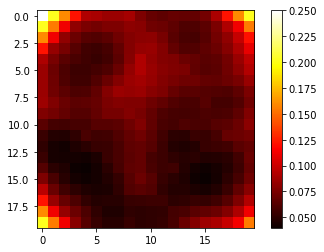

In [163]:
draw_graph()

In [143]:
x_input = on_sample(m).float()
y = model(x_input)
regularization = y**2
print(y)

tensor(1.00000e-02 *
       [ 6.9923])


In [84]:
model = DeepRitzNet(m)
model(torch.Tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

tensor(1.00000e-02 *
       [ 9.3990])

In [ ]:
#print the error
    if((i+1) % print_every_iter == 0):
        in_error = 0
        on_error = 0
        
        for t in range(n3):
            in_x_test = in_sample(m)
            in_error_instant = abs((model(in_x_test.float()) -
                                    U_groundtruth(in_x_test.float())).item())
            in_error = max(in_error, in_error_instant)
            
            on_x_test = on_sample(m)
            on_error_instant = abs((model(on_x_test.float()) -
                                    U_groundtruth(on_x_test.float())).item())
            on_error = max(on_error,on_error_instant)
            
        in_error_iter.append(in_error)
        on_error_iter.append(on_error)
        
        print("Error in Omega at the",i+1,"th iteration:",in_error)
        print("Error on the border of Omega at the",i+1,"th iteration:",on_error)

In [ ]:
for i in range(iterations):
    #calculate the loss 
    loss=torch.zeros(1)
    for t in range(n1):
        #if I miss out the ".float()" there will be an error and I don't know why
        #It seems to have something to do with the usage of relu()**3 in DeepRitzNet
        x_input=in_sample()
        y=model(x_input.float())
        #there will be an error without "retain_graph=True" , I don't know why
        y.backward(retain_graph=True)
        loss+=0.5*((x_input.grad.float()[0])**2+(x_input.grad.float()[1])**2)-y
    loss/=n1
    
    regularization=torch.zeros(1)
    for t in range(n2):
        x_input=on_sample().float()
        y=model(x_input)
        regularization+=y**2   
    regularization*=beta/n2
    
    loss+=regularization
    
    #and step the optimizer
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #print the error
    if((i+1)%print_every_iter==0):
        in_error=0
        on_error=0
        
        for t in range(n3):
            in_x_test=in_sample()
            in_error_instant=abs((model(in_x_test.float())-U_groundtruth(in_x_test.float())).item())
            in_error=max(in_error,in_error_instant)
            
            on_x_test=on_sample()
            on_error_instant=abs((model(on_x_test.float())-U_groundtruth(on_x_test.float())).item())
            on_error=max(on_error,on_error_instant)
            
        in_error_iter.append(in_error)
        on_error_iter.append(on_error)
        
        print("Loss at the",i+1,"th iteration:", loss)
        print("Error in Omega at the",i+1,"th iteration:",in_error)
        print("Error on the border of Omega at the",i+1,"th iteration:",on_error)
        
print("Traning Completed.")